**Pooya Kabiri - 96521434**

Importing prerequisites

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [15]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

# Augmented Reality

`AR(background, image)`: Gets two images as input, one background and one regular photo. Fits the photo into the rectangular frame on the background. Uses `cv2.findHomography` and `cv2.warpPerspective`. Returns the augmented image.

In [16]:
def AR(background, image):
    '''
    Adds the input image to the background image properly.
    
    Parameters:
        background (numpy.ndarray) : background image
        image (numpy.ndarray): input image
    
    Returns:
        numpy.ndarray: The result image.
    '''
    result = background.copy()
    
    src_points = np.float32([
        [0, 0],
        [0, 1799],
        [1199, 1799],
        [1199, 0]
    ])
    dst_points = np.float32([
        [148, 105],
        [143, 225],
        [236, 228],
        [237, 105]
    ])
    
    h, status = cv2.findHomography(src_points, dst_points)

    image_perspective = cv2.warpPerspective(image, h, (background.shape[1], background.shape[0]))

    for i in range(background.shape[0]):
        for j in range(background.shape[1]):
            if image_perspective[i, j].all() > 0:
                result[i, j] = image_perspective[i, j]    
    
    return result

Test of implementation.

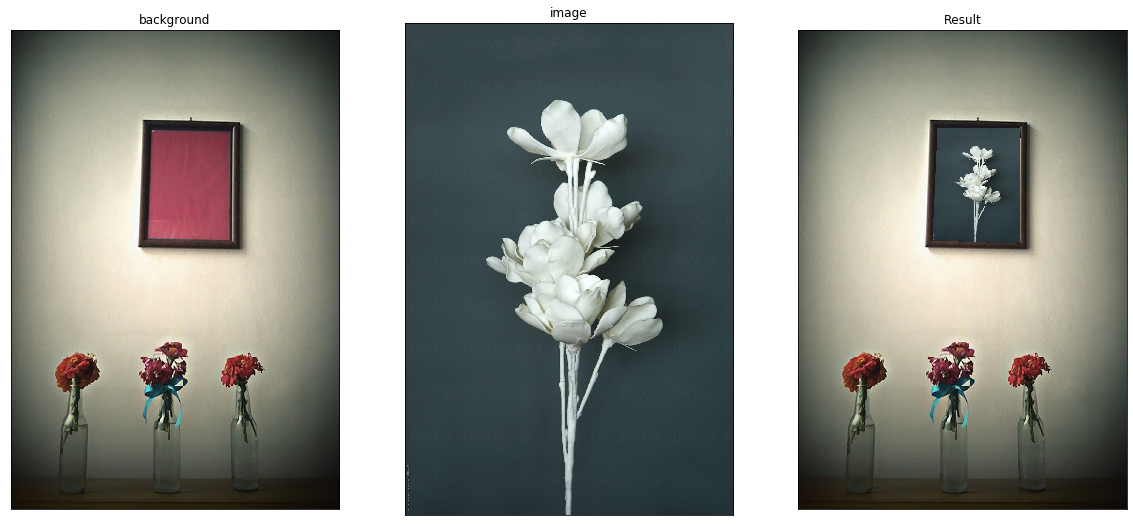

In [17]:
image_list = []

background = cv2.imread(os.path.join('images', 'background.jpg'))
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
image_list.append([background, 'background', 'img'])

image = cv2.imread(os.path.join('images', '1.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_list.append([image, 'image', 'img'])

image_list.append([AR(background, image), 'Result', 'img'])


plotter(image_list,1 , 3, True, 20, 10, '2')

# Image Threshold

## Global Otsu's Method

`compute_histogram(image)`: Gets image as input, computes it's histogram and returns it.

In [18]:
 def compute_histogram(image):
        
    histogram = np.zeros((256), np.int)
    np.add.at(histogram, image, 1)
    return histogram

`global_otsu(image)`: Gets image as input, iterates through all possible threshold values, returns the threshold minimuming the variance weighted equation.

In [19]:
def global_otsu(image):
    '''
    Applys global otsu on the input image.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result panorama image.
    '''
    
    sigma_optim = 100000000
    threshold = 0
    
    histogram = compute_histogram(image)
    
    total_count = np.sum(histogram)

    for t in range(1, 255):
        P1 = histogram[:t]
        P2 = histogram[t:]
        
        Q1 = np.sum(P1)
        Q2 = np.sum(P2)
        
        W1 = Q1 / total_count
        W2 = Q2 / total_count
        
        V1 = np.var(image[image < t])
        V2 = np.var(image[image >= t])
        
        Sigma = W1 * V1 + W2 * V2
        
        if Sigma < sigma_optim:
            sigma_optim = Sigma
            threshold = t
    
    image = np.where(image < threshold, 0, 255)
        
    
    return image

Test of implementation.

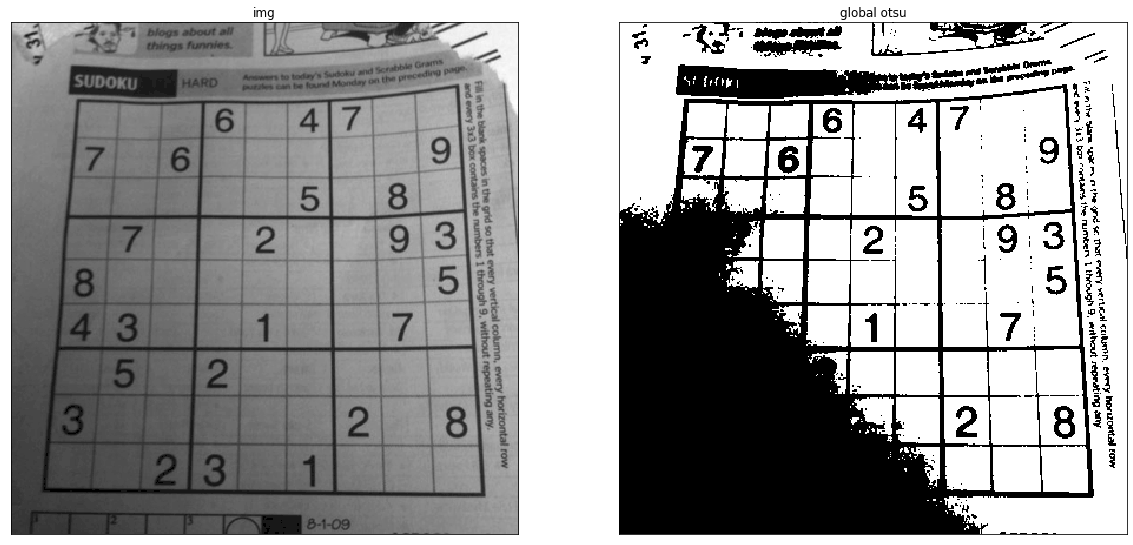

In [20]:
image_list = []

image = cv2.imread(os.path.join('images', 'q2.png'), cv2.IMREAD_GRAYSCALE)
image_list.append([image, 'img', 'img'])



image_list.append([global_otsu(image), 'global otsu', 'img'])

plotter(image_list, 1, 2, True, 20, 10, '3A')

## Partial (Local) Otsu's Method

`local_otsu(image)`: Gets image as input, slices the image in 4 parts, computes threshold for each part using above `global_otsu(image)` function. Stitches the threshold result to form a complete image and returns it.

In [21]:
def local_otsu(image):
    '''
    Applys local otsu on the input image.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result panorama image.
    '''
    
    result = np.zeros_like(image)
    rows, cols = image.shape
    
    x_mid = rows // 2
    y_mid = cols // 2

    result[:x_mid, :y_mid] = global_otsu(image[:x_mid, :y_mid])
    result[:x_mid, y_mid:] = global_otsu(image[:x_mid, y_mid:])
    result[x_mid:, :y_mid] = global_otsu(image[x_mid:, :y_mid])
    result[x_mid:, y_mid:] = global_otsu(image[x_mid:, y_mid:])
    
    return result

Test of implementation.

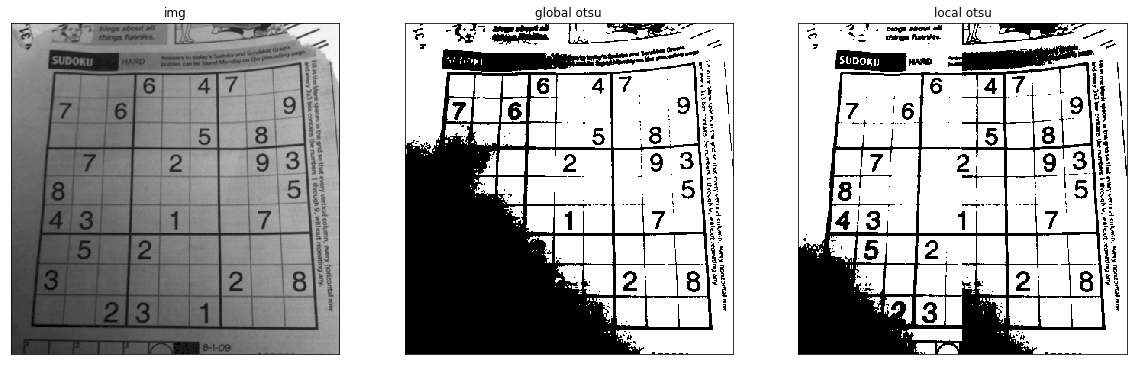

In [22]:
image_list = []

image = cv2.imread(os.path.join('images', 'q2.png'),cv2.IMREAD_GRAYSCALE)
image_list.append([image, 'img', 'img'])


image_list.append([global_otsu(image), 'global otsu', 'img'])
image_list.append([local_otsu(image), 'local otsu', 'img'])

plotter(image_list, 1, 3, True, 20, 10, '3B')

## Adaptive Threshold

`adaptive_th(image)`: Gets image as input, applies adaptive threshold for every pixel in the input image. Uses OpenCV method `cv2.adaptiveThreshold` to achieve thresholding. This method's parameters are:

**1. `src`:** The input image.

**2. `maxValue`:** Value of double type representing the value that is to be given if pixel value is more than the threshold value.

**3. `adaptiveMethod`:** Indicating adaptive method of threshold, can be **`ADAPTIVE_THRESH_MEAN_C`** in which threshold value is the mean of neighborhood area, or it can be **`ADAPTIVE_THRESH_GAUSSIAN_C`** in which threshold value is the weighted sum of neighborhood values where weights are a Gaussian kernel.

**4. `thresholdType`:** Type of threshold, here used **`cv2.THRESH_BINARY`**.

**5. `blockSize`:** The size of window calculating the adaptive threshold for each pixel.

**6. `C`:** Value of double type representing size of the pixelneighborhood used to calculate the threshold value.

In [23]:
def adaptive_th(image):
    '''
    Applys adaptive threshold on the input image.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result panorama image.
    '''
    
    result = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 19, 8)
    
    
    return result

Test of implementation.

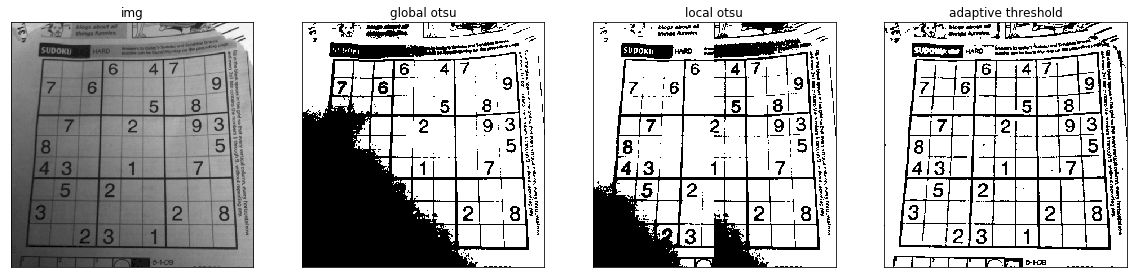

In [25]:
image_list = []

image = cv2.imread(os.path.join('images', 'q2.png'),cv2.IMREAD_GRAYSCALE)
image_list.append([image, 'img', 'img'])


image_list.append([global_otsu(image), 'global otsu', 'img'])
image_list.append([local_otsu(image), 'local otsu', 'img'])
image_list.append([adaptive_th(image), 'adaptive threshold', 'img'])

plotter(image_list, 1, 4, True, 20, 10, '3C')

# Normalized Cross Correlation

`get_keypoints(image)`: Gets image as input, computes the keypoints (corners) of the image and returns a mask of image which has True values for pixels which are keypoints. Uses `cv2.cornerHarris` for corner detection and `cv2.dilate` to distinguish important keypoints in the image.

In [26]:
def get_keypoints(image):
    
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image_harris = cv2.cornerHarris(image_gray, 5, 3, 0.05)
    image_key = cv2.dilate(image_harris, None) 
    key_points = image_key > 0.05 * image_key.max()
    
    return key_points

`clean_keypoints(keypoints, dist_offset, disc_offset)`: Gets image and required offsets as input, iterates through keypoints and eliminated keypoints which are out of bounds of index when window is on them, and also eliminates keypoints which are close together (neighborhood closer than a threshold i.e. `dist_offset`).

In [27]:
def clean_keypoints(keypoints, dist_offset, disc_offset):
    
    rows, cols = keypoints.shape
    
    for i in range(rows):
        for j in range(cols):
            if keypoints[i, j]:
                if i + disc_offset >= rows or j + disc_offset >= cols or i - disc_offset < 0 or j - disc_offset < 0:
                    keypoints[i, j] = False
                else:
                    keypoints[i - dist_offset:i + dist_offset + 1, j - dist_offset:j + dist_offset + 1] = False
                    keypoints[i, j] = True
                    
    return keypoints

`ncc(slice1, slice2)`: Calculates Normalized Cross Correlation for two slices (windows) of image and returns the ouput.

In [28]:
def ncc(slice1, slice2):
    return cv2.matchTemplate(slice1, slice2, cv2.TM_CCORR_NORMED)

`make_slice(image, i, j, offset)`: Slices image using `i, j, offset` which are given as inputs. Returns the slice of the image.

In [29]:
def make_slice(image, i, j, offset):
    return image[i - offset:i + offset + 1, j - offset:j + offset + 1, :]

`ncc_loop(image1, src_keypoints, image2, tar_keypoints, disc_size)`: Loops through two images and their corresponding keypoint coordinates. Tries to match each keypoint of first image to a keypoint of the second image by using maximum ncc scor for each two pait of windows. Uses `ncc`, `make_slice` methods. Returns first image keypoints alongside with their matched keypoints of the second image.

In [30]:
def ncc_loop(image1, src_keypoints, image2, tar_keypoints, disc_size):
    
    offset = disc_size // 2
    
    correspondence = []

    for src_point in src_keypoints:
        
        current_score = -1
        most_scored = None
        
        for tar_point in tar_keypoints:     
            
            slice1 = make_slice(image1, src_point[0], src_point[1], offset)
            slice2 = make_slice(image2, tar_point[0], tar_point[1], offset)

            ncc_score = ncc(slice1, slice2)
            
            if ncc_score > current_score and ncc_score > 0.85:
                current_score = ncc_score
                most_scored = tar_point
                
        correspondence.append(most_scored)
        
    return src_keypoints, correspondence

`zip_coordinates(keypoints)`: Zips coordinates of a True/False matrix in form of a list o tuples.

In [31]:
def zip_coordinates(keypoints):
    
    rows, cols = np.where(keypoints)
    coords = list(zip(rows, cols))
    
    return coords

`draw_combined_lines(srcs, dsts, image, width_to_add)`: Draw multi-colored lines on the concatenated image. Gets source and target coordinates of the lines, and handles the target coordinate expansion.

In [32]:
def draw_combined_lines(srcs, dsts, image, width_to_add):
    for src_point, tar_point in zip(srcs, dsts):
        
        r = np.random.randint(0, 255)
        g = np.random.randint(0, 255)
        b = np.random.randint(0, 255)

        src_inverted = (src_point[1], src_point[0])
        
        tar_inverted = (tar_point[1] + width_to_add, tar_point[0])
        
        cv2.line(image, src_inverted, tar_inverted, (r, g, b), 2)
    return image

`find_match(image1, image2)`: Findes matches between two images. Uses Normalized Cross Correlation for template (Window) matching. Uses all the above helper functions.

In [33]:
def find_match(image1, image2):
    '''
    Finds match points between two input images.
    
    Parameters:
        image1 (numpy.ndarray): input image.
        image2 (numpy.ndarray): second input image.
    
    Returns:
        numpy.ndarray: The result image.
    '''
    
    distance_threshold = 15
    dist_offset = distance_threshold // 2
    
    discriptor_size = 19
    disc_offset = discriptor_size // 2
    
    keypoints1 = get_keypoints(image1)
    keypoints2 = get_keypoints(image2)
    
    keypoints1 = clean_keypoints(keypoints1, dist_offset, disc_offset)
    keypoints2 = clean_keypoints(keypoints2, dist_offset, disc_offset)
    
    src_coordinates = zip_coordinates(keypoints1)
    tar_coordinates = zip_coordinates(keypoints2)
    
    srcs, dsts = ncc_loop(image1, src_coordinates, image2, tar_coordinates, discriptor_size)

    combined_image = np.concatenate([image1, image2], axis = -2)
    
    final_image = draw_combined_lines(srcs, dsts, combined_image, image2.shape[1])
    
    return final_image

Test of implementation.

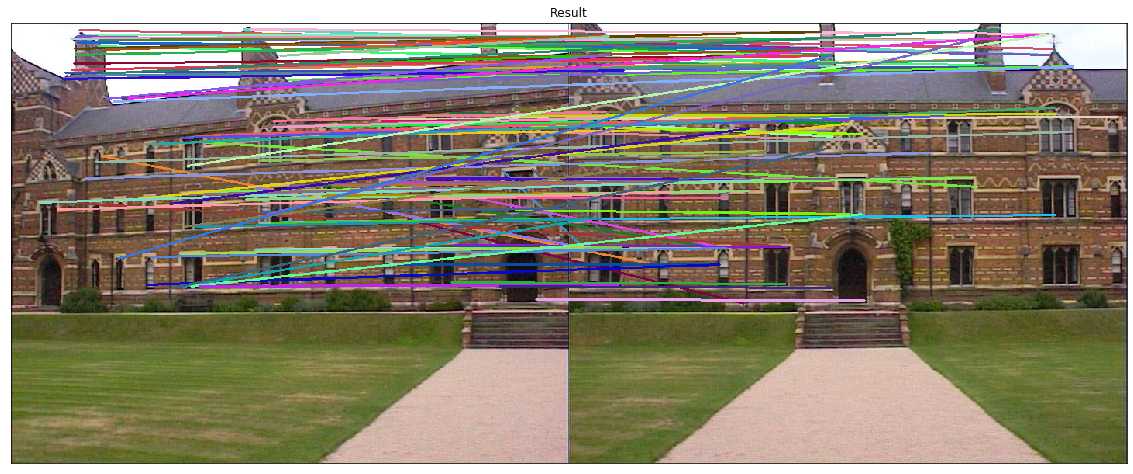

In [34]:
image_list = []

image1 = cv2.imread(os.path.join('images', 'building1.jpg'))
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)


image2 = cv2.imread(os.path.join('images', 'building2.jpg'))
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

image_list.append([find_match(image1,image2), 'Result', 'img'])

plotter(image_list,1 , 1, True, 20, 10, '4')